# MNIST

In [1]:
# Definiere einen Seed um stets dieselben Zufallszahlen zu erhalten

seed = 0

## Daten aufbereiten

In [2]:
# Downloaden des MNIST Datensatzes
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Trainingsdaten aufteilen in (kleines) Training-Set und Validation-Set
from sklearn.model_selection import train_test_split
train_images_partial, validation_images, train_labels_partial, validation_labels = \
    train_test_split(train_images, train_labels, test_size=0.2, random_state=seed)

Using TensorFlow backend.


Zeige die Grössen der einzelnen Datensätze:

(Technisch gesprochen handelt es sich dabei um Tensoren, also salopp gesagt um Matrizen, welche mehr als zwei Dimensionen aufweisen.)

In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
train_images_partial.shape

(48000, 28, 28)

In [5]:
validation_images.shape

(12000, 28, 28)

In [6]:
test_images.shape

(10000, 28, 28)

**Frage:** Was bedeuten die hier gezeigten Werte? Wie kommen sie zustande?

Eine bestimmte Ziffer kann wie folgt angezeigt werden:

(Falls die Ziffer nicht angezeigt wird, den untenstehenden Code-Block ein zweites Mal ausführen.)

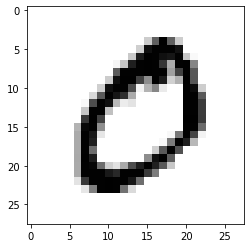

In [7]:
import matplotlib.pyplot as plt
import numpy as np
index = 1
plt.imshow(train_images[index], cmap=plt.cm.binary)
plt.show()

**Aufgabe:** Lassen Sie sich unterschiedliche Ziffern anzeigen um ein Gefühl für deren Aussehen zu erhalten.

Als Input in unser neuronales Netz benötigen wir eindimensionale Vektoren der Länge 784 (= 28 * 28). Um diese zu erhalten müssen wir die bestehenden Pixelwerte neu anordnen (`reshape()`).

In [8]:
# Bildhöhe und -breite bestimmen
(image_width, image_height) = train_images.shape[1:]

# Anzahl Pixel pro Bild berechnen
num_pixels = image_width * image_height

# Datensätze umformen
train_images = train_images.reshape((-1, num_pixels)) # -1 bedeutet: dieser Wert soll automatisch bestimmt werden
train_images_partial = train_images_partial.reshape((-1, num_pixels))
validation_images = validation_images.reshape((-1, num_pixels))
test_images = test_images.reshape((-1, num_pixels))



Die Pixelwerte zu 32-bit Floats umwandeln und in den Bereich [0,1] einpassen. Siehe https://en.wikipedia.org/wiki/Feature_scaling

In [9]:
train_images = train_images.astype('float32') / 255
train_images_partial = train_images_partial.astype('float32') / 255
validation_images = validation_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

Im Folgenden schauen wir uns die Labels der Daten an. Für jede Ziffer ist ein Integer-Wert hinterlegt, welcher aussagt, welche Ziffer im Bild erkannt werden sollte.

In [10]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Diese Form der Darstellung ist nicht ideal für die Verarbeitung durch ein neuronales Netz. Stattdessen möchten wir für jedes Bild einen Vektor im sogenannt kategorischen Format haben. Das bedeutet in unserem Fall, für jedes Bild einer Ziffer gibt es einen Vektor mit 10 Bits, bei welchem exakt ein Bit gesetzt ist. Der Index (d.h. die Position) des gesetzten Bits gibt an, um welche Ziffer es sich handelt.

Beispiel: Die Ziffer 2 wird codiert als [ 0, 0, 1, 0, 0, 0, 0, 0, 0, 0 ]

In [11]:
from keras.utils import to_categorical
train_labels_cat = to_categorical(train_labels)
train_labels_partial_cat = to_categorical(train_labels_partial)
validation_labels_cat = to_categorical(validation_labels)
test_labels_cat = to_categorical(test_labels)

In [12]:
train_labels_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

**Aufgabe:** Überprüfen Sie anhand einem oder zwei Fällen, ob die so erstellten Labels mit den in den Bildern sichtbaren Ziffern übereinstimmen.

Unsere Daten sind nun bereit, als Trainingsdaten verwendet zu werden.

## Neuronales Netz erstellen

In [13]:
from keras import models
from keras import layers

network = models.Sequential() # wir möchten eine Aneinanderreihung von mehreren Layern erstellen

Unser Netz soll aus zwei Layern bestehen:

- Hidden Layer: num_pixels Eingänge, 8 Neuronen/Ausgänge, ReLU Aktivierungsfunktion
- Output Layer: 10 Ausgänge (entspricht den Ziffern 0 bis 9), Softmax Aktivierungsfunktion

In [14]:
network.add(layers.Dense(8, activation='relu', input_shape=(num_pixels,)))
network.add(layers.Dense(10, activation='softmax'))

**Frage:** Weshalb müssen wir die Anzahl Eingänge beim zweiten Layer nicht definieren?

**Aufgabe:** Suchen Sie im Internet nach dem Aussehen der Softmax Funktion

Weiter definieren wir
- einen Optimizer (also den Algorithmus, welcher nach jeder Iteration die Gewichte/Schwellwerte konkret anpasst)
- eine Loss-Funktion
- eine Metrik (hier: der Anteil korrekt zugewiesener Ziffern), welche wir zusätzlich zum Loss beobachten möchten.

In [15]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Bemerkung: Abhängig von der genauen Problemstellung haben sich bestimmte Kombinationen von Aktivierungsfunktion im letzten Layer und Loss-Funktion bewährt: (Tabelle gemäss Chollet, S. 114)

| Problemstellung | Aktivierungsfunktion im letzten Layer | Loss-Funktion |
|:-----|:---:|---|
| Binary classification | `sigmoid` | `binary_crossentropy` |
| Multiclass, single-label classification | `softmax` | `categorical_crossentropy` |
| Multiclass, multilabel classification | `sigmoid` | `binary_crossentropy` |
| Regression to arbitrary values | None | `mse` |
| Regression to values between 0 and 1 | `sigmoid` | `mse` or `binary_crossentropy` |

In unserem Fall handelt es sich um ein Klassifikationsproblem, welches multiclass ist (es gibt mehr als zwei Klassen, nämlich zehn), aber jedes Sample hat genau ein Label.

## Training durchführen

Als nächsten Schritt möchten wir unser Netzwerk anhand der Trainingsdaten trainieren.

In [16]:
history = network.fit(train_images_partial, train_labels_partial_cat,
                      epochs=50,
                      batch_size=128,
                      validation_data=(validation_images, validation_labels_cat))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 1s 17us/step - loss: 0.9913 - accuracy: 0.7042 - val_loss: 0.4968 - val_accuracy: 0.8619
Epoch 2/50
48000/48000 [==============================] - 1s 15us/step - loss: 0.4396 - accuracy: 0.8737 - val_loss: 0.3798 - val_accuracy: 0.8928
Epoch 3/50
48000/48000 [==============================] - 1s 15us/step - loss: 0.3745 - accuracy: 0.8916 - val_loss: 0.3423 - val_accuracy: 0.9016
Epoch 4/50
48000/48000 [==============================] - 1s 15us/step - loss: 0.3450 - accuracy: 0.9011 - val_loss: 0.3258 - val_accuracy: 0.9051
Epoch 5/50
48000/48000 [==============================] - 1s 15us/step - loss: 0.3272 - accuracy: 0.9073 - val_loss: 0.3109 - val_accuracy: 0.9088
Epoch 6/50
48000/48000 [==============================] - 1s 15us/step - loss: 0.3150 - accuracy: 0.9110 - val_loss: 0.3018 - val_accuracy: 0.9125
Epoch 7/50
48000/48000 [==============================] - 1s 15us/st

## Trainingserfolg bestimmen

Wir vergleichen nun die Resultate auf dem Trainings- und dem Validation-Set.

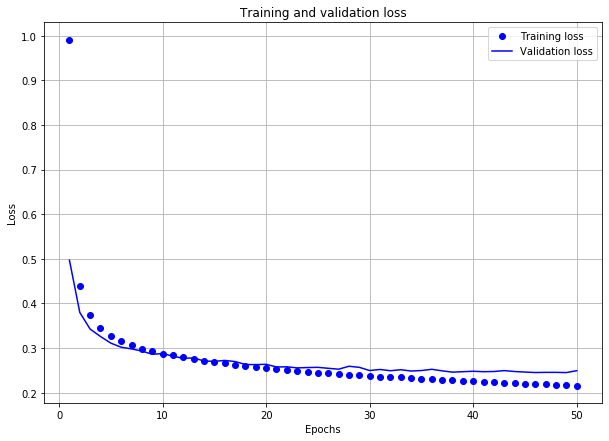

In [17]:
# Training und Validation loss anzeigen
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10, 7))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

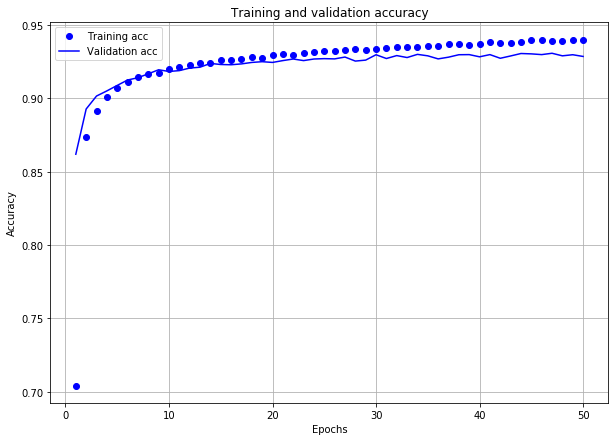

In [18]:
# Training und validation accuracy anzeigen
plt.figure(figsize=(10, 7))
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

Das Netz ist noch nicht ideal designt. Aus Erfahrung weiss man, dass ein gutes Netz eine Validation Accuracy von über 0.98 erreichen kann und das in weniger als 20 Epochen.

**Aufgabe:** Ändern Sie Hyperparameter, so dass Sie diese Werte ebenfalls erreichen. **Wichtig:** Sie müssen `network = models.Sequential()` und die darauffolgenden Befehle für jeden Ihrer Versuch erneut ausführen, ansonsten werden die Gewichte und Schwellwerte ihres Netzes nicht neu initialisiert und Sie erhalten verwirrende Resultate. Sobald Sie in der Grafik sehen, dass Sie in einer Epoche einen zufriedenstellenden Accuracy-Wert erhalten haben, gehen Sie wie folgt vor: Bestimmen Sie die Anzahl Trainingsepochen bei welcher der Übergang zwischen Under- und Overfitting stattfindet. Führen Sie das Training erneut aus, reduzieren Sie jedoch die Anzahl Trainingsepochen auf den vorher bestimmten Wert. Anschliessend können Sie eine abschliessende Evaluation der Klassifikationsperformance vornehmen.

Für ein einzelnes Bild kann eine Vorhersage wie folgt gemacht werden:

In [19]:
index = 2
prediction = network.predict(np.array([train_images[index]]))
np.argmax(prediction)

4

Wir zeigen uns das Bild und die zugehörigen Voraussagen an:

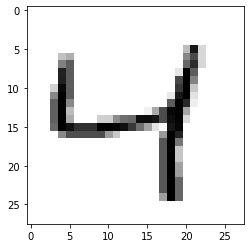

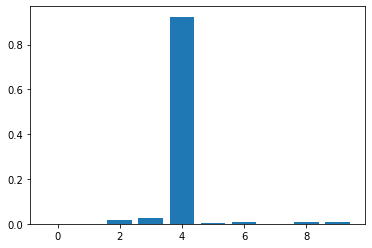

Most probable outcome: 4


In [20]:
plt.imshow(train_images[index].reshape((28,28)), cmap=plt.cm.binary)
plt.show()
plt.bar(np.arange(10),prediction[0])
plt.show()
print('Most probable outcome:', np.argmax(prediction))

## Abschliessende Evaluation der Performance auf dem Test-Set

In [21]:
test_loss, test_acc = network.evaluate(test_images, test_labels_cat)
print('test_loss:', test_loss)
print('test_acc:', test_acc)

10000/10000 [==============================] - 0s 18us/step
test_loss: 0.24921831702142955
test_acc: 0.9320999979972839
